# Veille Technologique - Modele CNN ResNet50 vs Vision Transformers (ViT)

## Imports et config

In [1]:
# %pip install timm

In [2]:
import os
import timm
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from torch import nn, optim
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

Device: cpu


## Chargement du dataset

In [3]:
SOURCES_PATH = "../Sources/"
CSV_FILE = "flipkart_com-ecommerce_sample_1050.csv"
CSV_FILEPATH = SOURCES_PATH + CSV_FILE
IMG_ROOT = Path(SOURCES_PATH + "Images/")

df = pd.read_csv(CSV_FILEPATH)

print('DataSet Shape = {}'.format(df.shape))
print('DataSet Memory Usage = {:.2f} MB'.format(df.memory_usage().sum() / 1024**2))

DataSet Shape = (1050, 15)
DataSet Memory Usage = 0.11 MB


#### Je cree ma colonne avec mes 7 categories

In [4]:
df['category_simple'] = df['product_category_tree'].apply(lambda x: x.split(' >> ')[0].split('["')[1])

#### On conserve uniquement les lignes avec des images existantes, mesure de securite

In [5]:
def img_exists(row):
    return (IMG_ROOT / str(row["image"])).exists()

In [6]:
df['img_path'] = df['image'].apply(lambda x: IMG_ROOT / str(x))
print("Nombre total de lignes/images:", len(df))

Nombre total de lignes/images: 1050


#### Encodage des labels

In [7]:
classes = sorted(df['category_simple'].unique())
class_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_class = {i: c for c, i in class_to_idx.items()}

In [8]:
df['label'] = df['category_simple'].map(class_to_idx)
num_classes = len(classes)
print("Classes:", classes)

Classes: ['Baby Care', 'Beauty and Personal Care', 'Computers', 'Home Decor & Festive Needs', 'Home Furnishing', 'Kitchen & Dining', 'Watches']


## Split train / val / test

#### Stratifier sur la categorie

In [9]:
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df["label"],
    random_state=SEED
)

In [10]:
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["label"],
    random_state=SEED
)

In [11]:
len(train_df), len(val_df), len(test_df)

(735, 157, 158)

## Dataset PyTorch + data augmentation

In [12]:
IMG_SIZE = 224

In [13]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet
        std=[0.229, 0.224, 0.225]
    ),
])

eval_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

#### Class pour les images

In [14]:
class FlipkartImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['img_path']).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = int(row['label'])
        return img, label

In [15]:
train_dataset = FlipkartImageDataset(train_df, transform=train_transform)
val_dataset   = FlipkartImageDataset(val_df, transform=eval_transform)
test_dataset  = FlipkartImageDataset(test_df, transform=eval_transform)

BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

## Fonctions utilitaires pour l'entrainement et l'evaluation

In [16]:
def mixup_data(x, y, alpha=0.4):
    if alpha <= 0:
        return x, y, y, 1.0
    lam = torch.distributions.Beta(alpha, alpha).sample().item()
    idx = torch.randperm(x.size(0), device=x.device)
    mixed_x = lam * x + (1 - lam) * x[idx]
    y_a, y_b = y, y[idx]
    return mixed_x, y_a, y_b, lam

def mixup_loss(criterion, logits, y_a, y_b, lam):
    return lam * criterion(logits, y_a) + (1 - lam) * criterion(logits, y_b)

In [17]:
def train_one_epoch(model, loader, criterion, optimizer, log_every=20, mixup_alpha=0.4):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(loader):
        images = images.to(device)
        labels = labels.to(device)

        if mixup_alpha and mixup_alpha > 0:
            images, y_a, y_b, lam = mixup_data(images, labels, alpha=mixup_alpha)

        optimizer.zero_grad()
        outputs = model(images)

        if mixup_alpha and mixup_alpha > 0:
            loss = mixup_loss(criterion, outputs, y_a, y_b, lam)
        else:
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        if i % log_every == 0:
            print(f"batch {i}/{len(loader)} | loss={loss.item():.3f} | acc={(correct/total):.3f}")

    return running_loss / len(loader.dataset), correct / total

In [18]:
@torch.inference_mode()
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    return epoch_loss, epoch_acc, np.array(all_labels), np.array(all_preds)

#### Visualisations

In [19]:
def plot_history(history, title=""):
    epochs = range(1, len(history["train_loss"]) + 1)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    axes[0].plot(epochs, history["train_loss"], label="Train")
    axes[0].plot(epochs, history["val_loss"],   label="Val")
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].legend()

    axes[1].plot(epochs, history["train_acc"], label="Train")
    axes[1].plot(epochs, history["val_acc"],   label="Val")
    axes[1].set_title("Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

## Modele CNN Baseline : ResNet50

In [20]:
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

#### On remplace la derniere couche FC par notre tete et on gele le backbone

In [21]:
for param in resnet.parameters():
    param.requires_grad = False

num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, num_classes)

resnet = resnet.to(device)
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=1e-4, weight_decay=1e-4)

In [23]:
EPOCHS = 15
best_val_acc = 0.0
history_resnet = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

In [24]:
patience = 5  # Nombre d'époques à attendre avant d'arrêter si aucune amélioration
patience_counter = 0 # Compteur pour le nombre d'époques sans amélioration

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(resnet, train_loader, criterion, optimizer)
    val_loss, val_acc, _, _ = evaluate(resnet, val_loader, criterion)

    history_resnet["train_loss"].append(train_loss)
    history_resnet["val_loss"].append(val_loss)
    history_resnet["train_acc"].append(train_acc)
    history_resnet["val_acc"].append(val_acc)

    print(f"[ResNet] Epoch {epoch:02d} | "
          f"Train loss={train_loss:.3f}, acc={train_acc:.3f} | "
          f"Val loss={val_loss:.3f}, acc={val_acc:.3f}")

    # Logique d'early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(resnet.state_dict(), "resnet50_best.pth")
        patience_counter = 0  # Réinitialiser le compteur de patience car une amélioration a été trouvée
    else:
        patience_counter += 1 # Incrémenter le compteur de patience

    if patience_counter >= patience: # Si le compteur dépasse la patience, arrêter l'entraînement
        print(f"Early stopping après {epoch} epochs. La précision de la validation ne s'est pas améliorée pour {patience} epochs consécutifs.")
        break

batch 0/46 | loss=1.993 | acc=0.062
batch 20/46 | loss=1.915 | acc=0.164


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=1.826 | acc=0.204
[ResNet] Epoch 01 | Train loss=1.903, acc=0.215 | Val loss=1.831, acc=0.408
batch 0/46 | loss=1.844 | acc=0.250
batch 20/46 | loss=1.788 | acc=0.372


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=1.781 | acc=0.369
[ResNet] Epoch 02 | Train loss=1.793, acc=0.374 | Val loss=1.723, acc=0.637
batch 0/46 | loss=1.669 | acc=0.750


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.591 | acc=0.521
batch 40/46 | loss=1.735 | acc=0.450
[ResNet] Epoch 03 | Train loss=1.678, acc=0.433 | Val loss=1.622, acc=0.707
batch 0/46 | loss=1.538 | acc=0.250
batch 20/46 | loss=1.819 | acc=0.426
batch 40/46 | loss=1.541 | acc=0.399


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ResNet] Epoch 04 | Train loss=1.617, acc=0.408 | Val loss=1.546, acc=0.739
batch 0/46 | loss=1.612 | acc=0.625


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.679 | acc=0.458
batch 40/46 | loss=1.571 | acc=0.422
[ResNet] Epoch 05 | Train loss=1.548, acc=0.433 | Val loss=1.475, acc=0.764


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 0/46 | loss=1.466 | acc=0.062
batch 20/46 | loss=1.400 | acc=0.369
batch 40/46 | loss=1.317 | acc=0.425
[ResNet] Epoch 06 | Train loss=1.434, acc=0.412 | Val loss=1.385, acc=0.764
batch 0/46 | loss=1.386 | acc=0.250


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.577 | acc=0.458
batch 40/46 | loss=1.271 | acc=0.459
[ResNet] Epoch 07 | Train loss=1.427, acc=0.445 | Val loss=1.308, acc=0.783
batch 0/46 | loss=1.335 | acc=0.062


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.610 | acc=0.426
batch 40/46 | loss=1.174 | acc=0.491
[ResNet] Epoch 08 | Train loss=1.344, acc=0.509 | Val loss=1.283, acc=0.783
batch 0/46 | loss=1.290 | acc=0.875


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.327 | acc=0.488
batch 40/46 | loss=1.560 | acc=0.465
[ResNet] Epoch 09 | Train loss=1.288, acc=0.473 | Val loss=1.228, acc=0.783
batch 0/46 | loss=1.223 | acc=0.062
batch 20/46 | loss=1.297 | acc=0.524


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=1.420 | acc=0.512
[ResNet] Epoch 10 | Train loss=1.257, acc=0.524 | Val loss=1.199, acc=0.790
batch 0/46 | loss=0.942 | acc=0.875


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.110 | acc=0.429
batch 40/46 | loss=1.326 | acc=0.451
[ResNet] Epoch 11 | Train loss=1.253, acc=0.450 | Val loss=1.172, acc=0.783
batch 0/46 | loss=1.336 | acc=0.188
batch 20/46 | loss=1.580 | acc=0.580


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=1.337 | acc=0.486
[ResNet] Epoch 12 | Train loss=1.191, acc=0.450 | Val loss=1.083, acc=0.777
batch 0/46 | loss=1.471 | acc=0.500


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.300 | acc=0.488
batch 40/46 | loss=1.241 | acc=0.547
[ResNet] Epoch 13 | Train loss=1.176, acc=0.562 | Val loss=1.056, acc=0.790
batch 0/46 | loss=0.894 | acc=0.875
batch 20/46 | loss=1.118 | acc=0.518
batch 40/46 | loss=1.285 | acc=0.506


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ResNet] Epoch 14 | Train loss=1.162, acc=0.510 | Val loss=1.033, acc=0.809
batch 0/46 | loss=0.875 | acc=0.125
batch 20/46 | loss=1.253 | acc=0.327


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (89503164 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=1.472 | acc=0.428
[ResNet] Epoch 15 | Train loss=1.136, acc=0.437 | Val loss=1.027, acc=0.777


#### A lancer

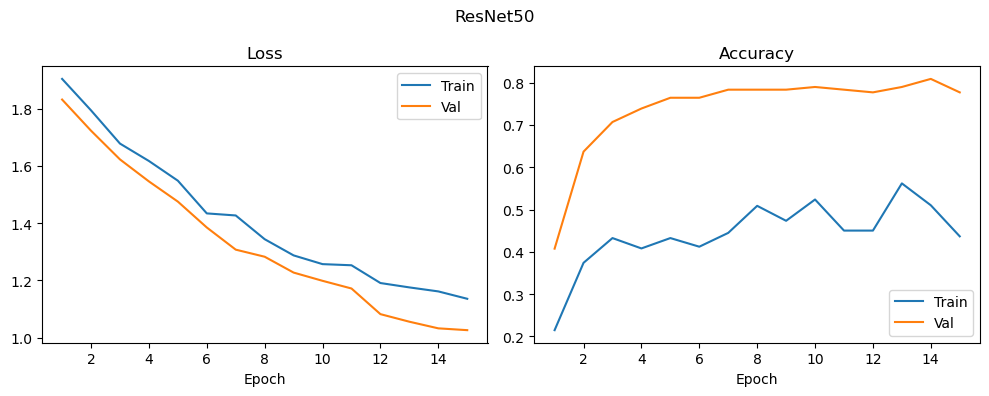

In [25]:
plot_history(history_resnet, title="ResNet50")

## Vision Transformer (ViT-B/16)

In [26]:
vit = timm.create_model(
    "vit_base_patch16_224",
    pretrained=True,
    num_classes=num_classes
)
vit = vit.to(device)

criterion_vit = nn.CrossEntropyLoss()
optimizer_vit = optim.AdamW(vit.parameters(), lr=2e-5, weight_decay=1e-4)

patience = 3  # Nombre d'époques à attendre avant d'arrêter si aucune amélioration
patience_counter = 0 # Compteur pour le nombre d'époques sans amélioration

EPOCHS_VIT = 15
best_val_acc_vit = 0.0
history_vit = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(1, EPOCHS_VIT + 1):
    train_loss, train_acc = train_one_epoch(vit, train_loader, criterion_vit, optimizer_vit)
    val_loss, val_acc, _, _ = evaluate(vit, val_loader, criterion_vit)

    history_vit["train_loss"].append(train_loss)
    history_vit["val_loss"].append(val_loss)
    history_vit["train_acc"].append(train_acc)
    history_vit["val_acc"].append(val_acc)

    print(f"[ViT] Epoch {epoch:02d} | "
          f"Train loss={train_loss:.3f}, acc={train_acc:.3f} | "
          f"Val loss={val_loss:.3f}, acc={val_acc:.3f}")

    if val_acc > best_val_acc_vit:
        best_val_acc_vit = val_acc
        torch.save(vit.state_dict(), "vit_base_patch16_224_best.pth")
        patience_counter = 0  # Réinitialiser le compteur de patience car une amélioration a été trouvée
    else:
        patience_counter += 1 # Incrémenter le compteur de patience

    if patience_counter >= patience: # Si le compteur dépasse la patience, arrêter l'entraînement
        print(f"Early stopping après {epoch} epochs. La précision de la validation ne s'est pas améliorée pour {patience} epochs consécutifs.")
        break

batch 0/46 | loss=2.492 | acc=0.000
batch 20/46 | loss=1.020 | acc=0.301


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=0.941 | acc=0.349
[ViT] Epoch 01 | Train loss=1.292, acc=0.373 | Val loss=0.694, acc=0.790
batch 0/46 | loss=0.894 | acc=0.375
batch 20/46 | loss=0.709 | acc=0.574
batch 40/46 | loss=0.225 | acc=0.622


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Epoch 02 | Train loss=0.757, acc=0.638 | Val loss=0.470, acc=0.854
batch 0/46 | loss=0.133 | acc=1.000


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=0.231 | acc=0.554
batch 40/46 | loss=0.628 | acc=0.517
[ViT] Epoch 03 | Train loss=0.554, acc=0.522 | Val loss=0.446, acc=0.860
batch 0/46 | loss=0.116 | acc=1.000
batch 20/46 | loss=0.637 | acc=0.744


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=0.233 | acc=0.607
[ViT] Epoch 04 | Train loss=0.532, acc=0.571 | Val loss=0.493, acc=0.847
batch 0/46 | loss=0.388 | acc=0.250
batch 20/46 | loss=0.557 | acc=0.595


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=0.904 | acc=0.652
[ViT] Epoch 05 | Train loss=0.481, acc=0.669 | Val loss=0.461, acc=0.828
batch 0/46 | loss=0.416 | acc=0.938
batch 20/46 | loss=0.899 | acc=0.527


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=1.035 | acc=0.523
[ViT] Epoch 06 | Train loss=0.596, acc=0.531 | Val loss=0.430, acc=0.854
Early stopping après 6 epochs. La précision de la validation ne s'est pas améliorée pour 3 epochs consécutifs.


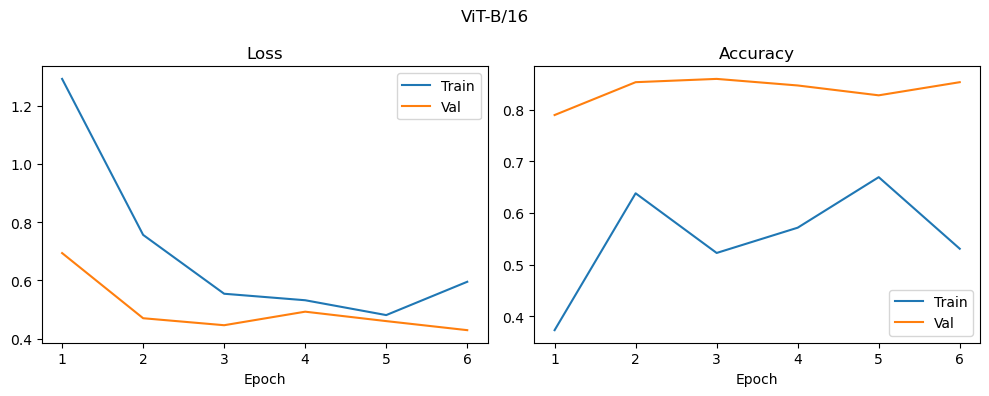

In [27]:
plot_history(history_vit, title="ViT-B/16")

## Évaluation finale sur le test set

ResNet50 - Test loss=0.992, acc=0.848
                            precision    recall  f1-score   support

                 Baby Care       0.78      0.82      0.80        22
  Beauty and Personal Care       0.89      0.77      0.83        22
                 Computers       0.91      0.87      0.89        23
Home Decor & Festive Needs       0.86      0.78      0.82        23
           Home Furnishing       0.72      0.78      0.75        23
          Kitchen & Dining       0.81      0.95      0.88        22
                   Watches       1.00      0.96      0.98        23

                  accuracy                           0.85       158
                 macro avg       0.85      0.85      0.85       158
              weighted avg       0.85      0.85      0.85       158

ViT-B/16 - Test loss=0.377, acc=0.886
                            precision    recall  f1-score   support

                 Baby Care       0.74      0.91      0.82        22
  Beauty and Personal Care       0.9

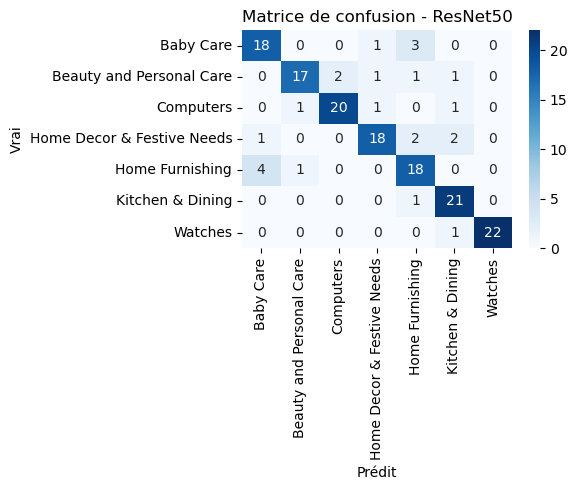

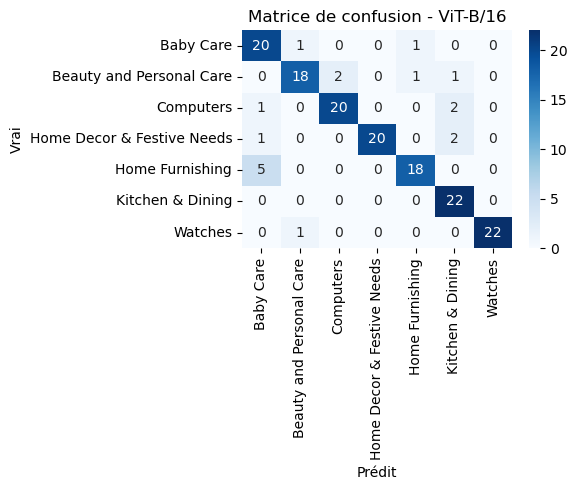

In [28]:
# Charger les meilleurs poids
resnet.load_state_dict(torch.load("resnet50_best.pth", map_location=device))
vit.load_state_dict(torch.load("vit_base_patch16_224_best.pth", map_location=device))

# ResNet
test_loss_r, test_acc_r, y_true_r, y_pred_r = evaluate(resnet, test_loader, criterion)
print(f"ResNet50 - Test loss={test_loss_r:.3f}, acc={test_acc_r:.3f}")
print(classification_report(y_true_r, y_pred_r, target_names=classes))

# ViT
test_loss_v, test_acc_v, y_true_v, y_pred_v = evaluate(vit, test_loader, criterion_vit)
print(f"ViT-B/16 - Test loss={test_loss_v:.3f}, acc={test_acc_v:.3f}")
print(classification_report(y_true_v, y_pred_v, target_names=classes))

# Matrices de confusion
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Prédit")
    plt.ylabel("Vrai")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_confusion(y_true_r, y_pred_r, "Matrice de confusion - ResNet50")
plot_confusion(y_true_v, y_pred_v, "Matrice de confusion - ViT-B/16")

## Phase d'amelioration du ViT

### Phase 1

In [29]:
vit = timm.create_model(
    "vit_base_patch16_224",
    pretrained=True,
    num_classes=num_classes,
    drop_rate=0.1,        # dropout
    drop_path_rate=0.1    # stochastic depth
).to(device)

In [30]:
# on freeze tout
for p in vit.parameters():
    p.requires_grad = False

# on degele la head et le classifier
for name, p in vit.named_parameters():
    if "head" in name:
        p.requires_grad = True

criterion_vit = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer_vit = optim.AdamW(
    filter(lambda p: p.requires_grad, vit.parameters()),
    lr=1e-3,
    weight_decay=0.05
)

EPOCHS_PHASE1 = 5

### Boucle d'entrainment phase 1

In [31]:
best_val_loss = float("inf")

history_vit = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(1, EPOCHS_PHASE1 + 1):
    train_loss, train_acc = train_one_epoch(vit, train_loader, criterion_vit, optimizer_vit)
    val_loss, val_acc, _, _ = evaluate(vit, val_loader, criterion_vit)

    history_vit["train_loss"].append(train_loss)
    history_vit["val_loss"].append(val_loss)
    history_vit["train_acc"].append(train_acc)
    history_vit["val_acc"].append(val_acc)

    print(f"[ViT] Epoch {epoch:02d} | Train loss={train_loss:.3f}, acc={train_acc:.3f} | Val loss={val_loss:.3f}, acc={val_acc:.3f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(vit.state_dict(), "vit_phase1_best.pth")

batch 0/46 | loss=2.467 | acc=0.125
batch 20/46 | loss=1.239 | acc=0.348


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=1.790 | acc=0.415
[ViT] Epoch 01 | Train loss=1.530, acc=0.407 | Val loss=0.932, acc=0.809
batch 0/46 | loss=1.734 | acc=0.438
batch 20/46 | loss=1.519 | acc=0.536


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (91406795 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=1.426 | acc=0.497
[ViT] Epoch 02 | Train loss=1.248, acc=0.503 | Val loss=0.867, acc=0.822
batch 0/46 | loss=1.795 | acc=0.125


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.417 | acc=0.512
batch 40/46 | loss=1.039 | acc=0.518
[ViT] Epoch 03 | Train loss=1.266, acc=0.533 | Val loss=0.871, acc=0.841
batch 0/46 | loss=1.433 | acc=0.562


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.354 | acc=0.476
batch 40/46 | loss=0.768 | acc=0.529
[ViT] Epoch 04 | Train loss=1.207, acc=0.527 | Val loss=0.866, acc=0.854
batch 0/46 | loss=1.028 | acc=0.188
batch 20/46 | loss=0.970 | acc=0.500


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=0.797 | acc=0.476
[ViT] Epoch 05 | Train loss=1.051, acc=0.486 | Val loss=0.846, acc=0.866


In [32]:
vit.load_state_dict(torch.load("vit_phase1_best.pth", map_location=device))

<All keys matched successfully>

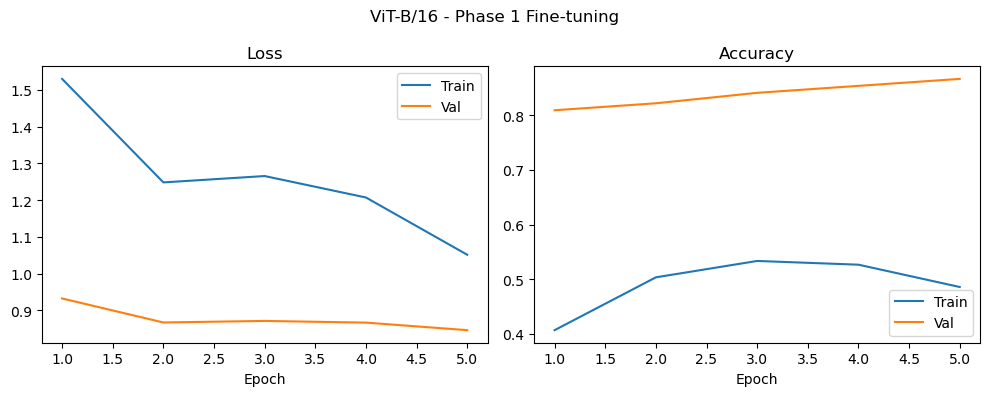

In [33]:
plot_history(history_vit, title="ViT-B/16 - Phase 1 Fine-tuning")

### Phase 2

In [34]:
# on degele head + derniers blocks
for name, p in vit.named_parameters():
    if ("blocks.10" in name) or ("blocks.11" in name) or ("head" in name) or ("norm" in name):
        p.requires_grad = True

# LR plus bas pour backbone, plus haut pour head
backbone_params = []
head_params = []

for name, p in vit.named_parameters():
    if not p.requires_grad:
        continue
    if "head" in name:
        head_params.append(p)
    else:
        backbone_params.append(p)

optimizer_vit = optim.AdamW(
    [
        {"params": backbone_params, "lr": 5e-5},
        {"params": head_params, "lr": 2e-4},
    ],
    weight_decay=0.05
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_vit, mode="min", factor=0.5, patience=2
)

EPOCHS_PHASE2 = 10

### Boucle d'entrainement phase 2

In [35]:
patience = 5
min_delta = 1e-3
best_val_loss = float("inf")
patience_counter = 0

history_vit = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(1, EPOCHS_PHASE2 + 1):
    train_loss, train_acc = train_one_epoch(vit, train_loader, criterion_vit, optimizer_vit)
    val_loss, val_acc, _, _ = evaluate(vit, val_loader, criterion_vit)

    history_vit["train_loss"].append(train_loss)
    history_vit["val_loss"].append(val_loss)
    history_vit["train_acc"].append(train_acc)
    history_vit["val_acc"].append(val_acc)

    print(f"[ViT] Epoch {epoch:02d} | Train loss={train_loss:.3f}, acc={train_acc:.3f} | Val loss={val_loss:.3f}, acc={val_acc:.3f}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        torch.save(vit.state_dict(), "vit_phase2_best.pth")
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping après {epoch} epochs (val_loss n'améliore plus).")
        break

batch 0/46 | loss=1.012 | acc=0.062


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.014 | acc=0.554
batch 40/46 | loss=0.650 | acc=0.578
[ViT] Epoch 01 | Train loss=1.061, acc=0.554 | Val loss=0.833, acc=0.854
batch 0/46 | loss=0.925 | acc=0.875


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=0.858 | acc=0.497
batch 40/46 | loss=1.446 | acc=0.553
[ViT] Epoch 02 | Train loss=1.057, acc=0.578 | Val loss=0.816, acc=0.847
batch 0/46 | loss=0.628 | acc=0.125
batch 20/46 | loss=0.993 | acc=0.539


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=0.817 | acc=0.569
[ViT] Epoch 03 | Train loss=1.004, acc=0.543 | Val loss=0.803, acc=0.860
batch 0/46 | loss=1.034 | acc=0.188


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.415 | acc=0.443
batch 40/46 | loss=0.714 | acc=0.511
[ViT] Epoch 04 | Train loss=0.999, acc=0.533 | Val loss=0.786, acc=0.873
batch 0/46 | loss=0.993 | acc=0.250
batch 20/46 | loss=1.042 | acc=0.610
batch 40/46 | loss=1.135 | acc=0.654


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[ViT] Epoch 05 | Train loss=0.951, acc=0.688 | Val loss=0.772, acc=0.873
batch 0/46 | loss=0.877 | acc=0.125
batch 20/46 | loss=1.121 | acc=0.476


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=0.612 | acc=0.448
[ViT] Epoch 06 | Train loss=0.895, acc=0.501 | Val loss=0.806, acc=0.847
batch 0/46 | loss=0.894 | acc=1.000


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=1.289 | acc=0.524
batch 40/46 | loss=0.824 | acc=0.581
[ViT] Epoch 07 | Train loss=0.940, acc=0.599 | Val loss=0.777, acc=0.860
batch 0/46 | loss=0.879 | acc=0.375


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 20/46 | loss=0.567 | acc=0.527
batch 40/46 | loss=0.524 | acc=0.524
[ViT] Epoch 08 | Train loss=0.882, acc=0.516 | Val loss=0.807, acc=0.841
batch 0/46 | loss=0.553 | acc=1.000
batch 20/46 | loss=0.814 | acc=0.673


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=1.356 | acc=0.675
[ViT] Epoch 09 | Train loss=0.941, acc=0.667 | Val loss=0.778, acc=0.860
batch 0/46 | loss=0.533 | acc=1.000
batch 20/46 | loss=0.534 | acc=0.661


c:\Users\cosic\anaconda3\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


batch 40/46 | loss=1.476 | acc=0.605
[ViT] Epoch 10 | Train loss=0.870, acc=0.580 | Val loss=0.780, acc=0.854
Early stopping après 10 epochs (val_loss n'améliore plus).


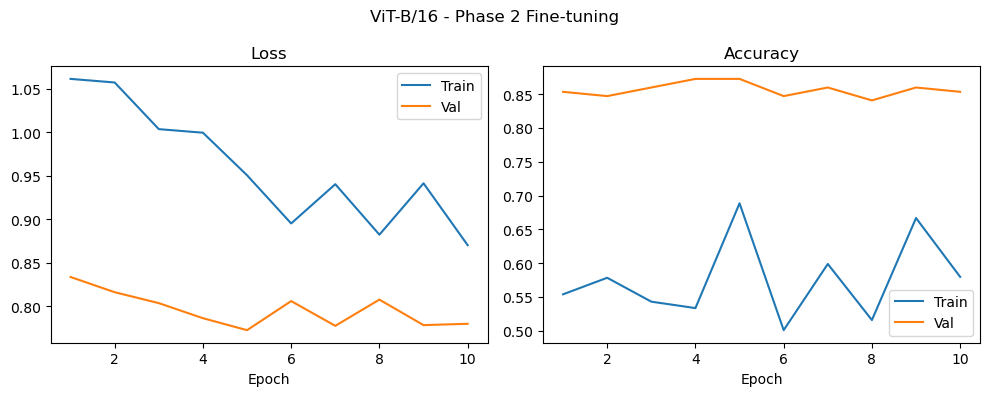

In [36]:
plot_history(history_vit, title="ViT-B/16 - Phase 2 Fine-tuning")

### je charge le meilleur modele

In [37]:
vit.load_state_dict(torch.load("vit_phase2_best.pth", map_location=device))
vit.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [38]:
test_loss, test_acc, y_true, y_pred = evaluate(vit, test_loader, criterion_vit)

print(f"[ViT] Test loss={test_loss:.3f} | acc={test_acc:.3f}")

[ViT] Test loss=0.691 | acc=0.918


                            precision    recall  f1-score   support

                 Baby Care       0.74      0.91      0.82        22
  Beauty and Personal Care       0.90      0.82      0.86        22
                 Computers       0.91      0.87      0.89        23
Home Decor & Festive Needs       1.00      0.87      0.93        23
           Home Furnishing       0.90      0.78      0.84        23
          Kitchen & Dining       0.81      1.00      0.90        22
                   Watches       1.00      0.96      0.98        23

                  accuracy                           0.89       158
                 macro avg       0.89      0.89      0.89       158
              weighted avg       0.90      0.89      0.89       158



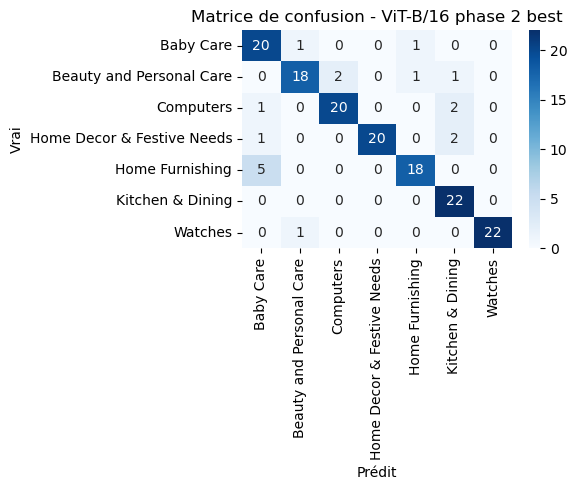

In [39]:
print(classification_report(y_true_v, y_pred_v, target_names=classes))

# Matrices de confusion
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Prédit")
    plt.ylabel("Vrai")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_confusion(y_true_v, y_pred_v, "Matrice de confusion - ViT-B/16 phase 2 best")

In [40]:
(y_true == y_pred).mean()

0.9177215189873418